In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [160]:
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
def label_count(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [162]:
def prepare_data(ticker):
    base_path = "/content/drive/My Drive"
    stock_price = pd.read_csv(f"{base_path}/dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()

    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    stock_price['200_ma'] = stock_price['prv_close'].rolling(window=200, min_periods=1).mean()
    stock_price['50_ma'] = stock_price['prv_close'].rolling(window=50, min_periods=1).mean()

    stock_news = pd.read_csv(f"{base_path}/dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0
    stock_news['neg_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_mean'] = np.nan
    stock_news['pos_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_mean'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    df_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [label_count(['positive']), label_count(['negative'])], '200_ma': 'first', '50_ma': 'first',
        'sentiment_score': 'mean', 'pos_score': 'mean', 'neg_score': 'mean', 'pos_mean': 'mean', 'neg_mean': 'mean'
    }).fillna(0.0).reset_index()
    df_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative',
                           '200_ma', '50_ma', 'all_score', 'pos_score', 'neg_score', 'pos_mean', 'neg_mean']
    return df_gp

In [163]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'NVDA']
ticker = tickers[0]
df_gp = prepare_data(ticker)
df_gp

<ipython-input-161-cc6a419d00d3>:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


,trade_date,prv_close,delta,close,open,high,low,positive,negative,200_ma,50_ma,all_score,pos_score,neg_score,pos_mean,neg_mean
0,2022-10-31,0.00,0.00,153.34,153.155,154.240,151.92,0.275862,0.137931,0.000000,0.000000,0.096446,0.220498,-0.124052,0.799306,-0.899377
1,2022-11-01,153.34,-2.69,150.65,155.080,155.450,149.13,0.166667,0.277778,153.340000,153.340000,-0.085231,0.146493,-0.231724,0.878957,-0.834206
2,2022-11-02,150.65,-5.62,145.03,148.945,152.170,145.00,0.285714,0.142857,151.995000,151.995000,0.103546,0.238440,-0.134894,0.834540,-0.944261
3,2022-11-03,145.03,-6.15,138.88,142.060,142.800,138.75,0.117647,0.529412,149.673333,149.673333,-0.348146,0.090076,-0.438222,0.765643,-0.827752
4,2022-11-04,138.88,-0.50,138.38,142.090,142.670,134.38,0.117647,0.352941,146.975000,146.975000,-0.214672,0.083690,-0.298362,0.711366,-0.845359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-10-23,235.86,-5.10,230.76,234.080,235.144,227.76,0.500000,0.333333,200.375500,226.301000,0.085070,0.404759,-0.319689,0.809518,-0.959066
498,2024-10-24,230.76,-0.19,230.57,229.980,230.820,228.41,0.600000,0.000000,200.601500,226.490800,0.525094,0.525094,0.000000,0.875157,0.000000
499,2024-10-25,230.57,0.84,231.41,229.740,233.220,229.57,0.400000,0.200000,200.828650,226.667800,0.233975,0.330385,-0.096410,0.825962,-0.482050
500,2024-10-28,231.41,1.99,233.40,233.320,234.730,232.55,0.400000,0.000000,201.054750,226.801600,0.274372,0.274372,0.000000,0.685930,0.000000


In [164]:
def test_relevance(cols):
    X, y = df_gp[cols], df_gp['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [165]:
test_relevance(['negative'])

(6.818201284096953, 0.02640880698933079, array([-3.21031719]))

In [166]:
test_relevance(['all_score']),

((6.736621940179093, 0.03805776357781865, array([2.54353499])),)

In [167]:
test_relevance(['pos_score'])

(6.853155119499482, 0.02141764511365818, array([2.86719135]))

In [168]:
test_relevance(['neg_score'])

(6.799643484522392, 0.029058730257156884, array([3.87830153]))

In [169]:
test_relevance(['negative', 'neg_mean'])

(6.818157827214848, 0.02641501232647614, array([-3.17721773,  0.02711697]))

In [170]:
test_relevance(['positive', 'negative'])

(6.751657933019468, 0.035910729543827236, array([ 1.66057666, -2.52924482]))

In [171]:
test_relevance(['pos_score', 'neg_score'])

(6.729850348260034, 0.039024699281291375, array([2.05014963, 3.16447434]))

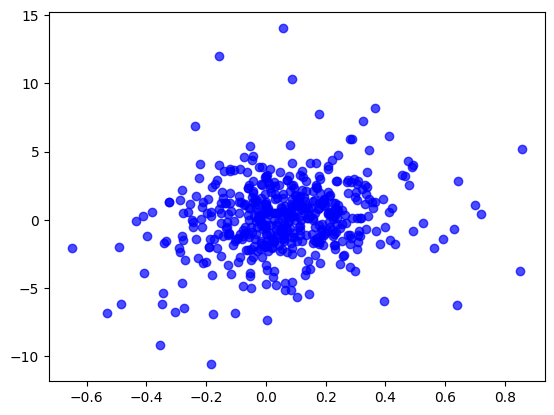

In [172]:
import matplotlib.pyplot as plt

plt.scatter(df_gp['all_score'], df_gp['delta'], color='blue', alpha=0.7)

In [173]:
def preprocess(df_gp, feat_cols, seq_length=50, offset=0):
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(df_gp[feat_cols])

    X = []
    y = []
    st = seq_length + offset
    for i in range(st, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1).to(device)

    split_index = int(len(X) * 0.95)
    ed = st + split_index
    X, X_test = X[:split_index], X[split_index:]
    y, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)

    return X, y, X_train, X_val, X_test, y_train, y_val, y_test, st, ed

In [174]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])

    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [175]:
feat_dict = {
    'AAPL': ['neg_score', 'prv_close', '50_ma', 'delta'],
    'GOOGL': ['neg_score', 'prv_close', '50_ma', 'delta'],
    'other': ['neg_score', 'prv_close', 'delta'],
}
epoch_dict = {
    'other': 1000,
}

In [176]:
feat_cols = feat_dict[ticker] if ticker in feat_dict else feat_dict['other']
X, y, X_train, X_val, X_test, y_train, y_val, y_test, st, ed = preprocess(df_gp, feat_cols)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape, st, ed

(torch.Size([407, 50, 4]),
 torch.Size([22, 50, 4]),
 torch.Size([23, 50, 4]),
 torch.Size([407, 1]),
 torch.Size([22, 1]),
 torch.Size([23, 1]),
 50,
 479)

In [216]:
def split_set(X, y, num=20):
    X_list = []
    y_list = []
    for i in range(num):
        X_train, y_train = [], []
        X_val, y_val = [], []
        for j in range(X.shape[0]):
            if j % num != i:
                X_train.append(X[j].numpy())
                y_train.append(y[j].numpy())
            else:
                X_val.append(X[j].numpy())
                y_val.append(y[j].numpy())
        X_list.append((
            torch.tensor(np.array(X_train)).to(device),
            torch.tensor(np.array(X_val)).to(device)
        ))
        y_list.append((
            torch.tensor(np.array(y_train)).to(device),
            torch.tensor(np.array(y_val)).to(device)
        ))
    return X_list, y_list

In [217]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, mute=False):
    num_epochs = epoch_dict[ticker] if ticker in epoch_dict else epoch_dict['other']
    model = SimpleLSTM(feat_size=[len(feat_cols), 32, 64, 1], layers=2, dropout=0.5).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    val_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        model.eval()
        if mute and epoch < num_epochs-1:
            continue
        with torch.no_grad():
            train_loss.append(loss.item())
            val_loss.append(criterion(model(X_val), y_val).item())
            test_loss.append(criterion(model(X_test), y_test).item())
            if len(train_loss) >= 10 or mute:
                print(f"Epoch {epoch}, Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}, Test Loss: {np.mean(test_loss):.4f}")
                train_loss.clear()
                val_loss.clear()
                test_loss.clear()
    return model, criterion


In [218]:
def simulate(X, y, X_test, y_test):
    y_pred_list, y_pred_rsl = [], []
    X_list, y_list = split_set(X, y)
    for X_t, y_t in zip(X_list, y_list):
        X_train, X_val = X_t
        y_train, y_val = y_t
        model, _ = train(X_train, X_val, X_test, y_train, y_val, y_test, True)
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val).squeeze().numpy().cpu()
            y_pred_list.append(y_pred)
    for i in range(len(y_pred_list[0])):
        for j in range(len(y_pred_list)):
            if i < len(y_pred_list[j]):
                y_pred_rsl.append(y_pred_list[j][i])
    return np.array(y_pred_rsl)

In [180]:
model, criterion = train(X_train, X_val, X_test, y_train, y_val, y_test)
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Epoch 9, Train Loss: 0.8979, Val Loss: 1.2218, Test Loss: 1.2483
Epoch 19, Train Loss: 0.8918, Val Loss: 1.1870, Test Loss: 1.2658
Epoch 29, Train Loss: 0.8864, Val Loss: 1.1946, Test Loss: 1.2696
Epoch 39, Train Loss: 0.8727, Val Loss: 1.1642, Test Loss: 1.2797
Epoch 49, Train Loss: 0.8330, Val Loss: 1.1746, Test Loss: 1.2920
Epoch 59, Train Loss: 0.7960, Val Loss: 1.2462, Test Loss: 1.4934
Epoch 69, Train Loss: 0.7780, Val Loss: 1.2497, Test Loss: 1.3860
Epoch 79, Train Loss: 0.7564, Val Loss: 1.2253, Test Loss: 1.4014
Epoch 89, Train Loss: 0.7656, Val Loss: 1.2945, Test Loss: 1.3784
Epoch 99, Train Loss: 0.7471, Val Loss: 1.2717, Test Loss: 1.3976
Epoch 109, Train Loss: 0.7244, Val Loss: 1.2650, Test Loss: 1.3711
Epoch 119, Train Loss: 0.6967, Val Loss: 1.2242, Test Loss: 1.4155
Epoch 129, Train Loss: 0.6775, Val Loss: 1.2027, Test Loss: 1.5660
Epoch 139, Train Loss: 0.6737, Val Loss: 1.1955, Test Loss: 1.6553
Epoch 149, Train Loss: 0.6528, Val Loss: 1.2233, Test Loss: 1.6813
Epoch 

In [181]:
def visualize(pred, ref, limit=1000):
    time = np.arange(len(pred))

    plt.plot(time[-limit:], pred[-limit:], label='Predicted Price', color='blue')
    plt.plot(time[-limit:], ref[-limit:], label='Real Price', color='orange')
    plt.xlabel('Trade Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

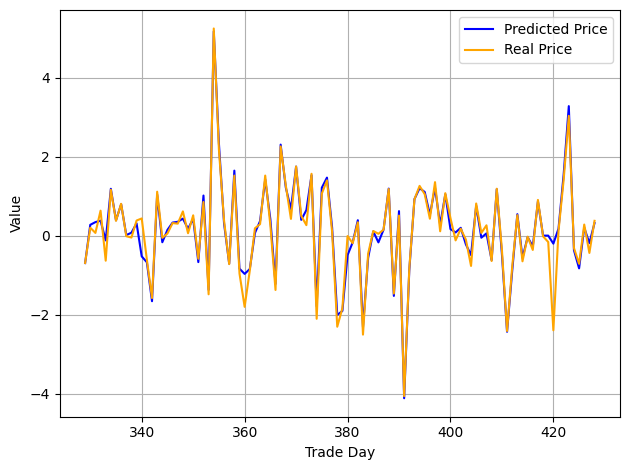

array([[1.       , 0.9549131],
       [0.9549131, 1.       ]])

In [182]:
y_ref1 = y.squeeze().cpu()
with torch.no_grad():
    y_pred1 = model(X).squeeze().cpu()
visualize(y_pred1, y_ref1, 100)
np.corrcoef(y_pred1, y_ref1)

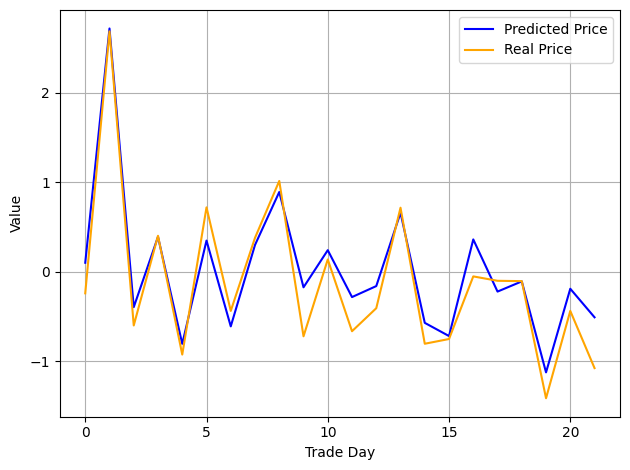

array([[1.        , 0.96503211],
       [0.96503211, 1.        ]])

In [183]:
y_ref2 = y_val.squeeze().cpu()
with torch.no_grad():
    y_pred2 = model(X_val).squeeze().cpu()
visualize(y_pred2, y_ref2)
np.corrcoef(y_pred2, y_ref2)

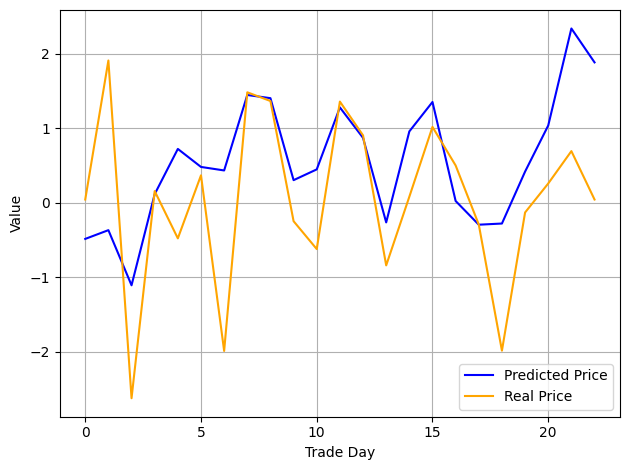

array([[1.        , 0.52727077],
       [0.52727077, 1.        ]])

In [184]:
y_ref3 = y_test.squeeze().cpu()
with torch.no_grad():
    y_pred3 = model(X_test).squeeze().cpu()
visualize(y_pred3, y_ref3)
np.corrcoef(y_pred3, y_ref3)

In [185]:
aveg_error1 = np.abs(y_pred1 - y_ref1).mean()
aveg_delta1 = np.abs(y_ref1).mean()
aveg_error1 / aveg_delta1, aveg_delta1

(tensor(0.2655), tensor(0.7008))

In [186]:
pred_delta = y_pred1 * df_gp['delta'].std() + df_gp['delta'].mean()
real_price = df_gp['close'][st:ed].to_numpy()
real_delta =  df_gp['delta'][st:ed].to_numpy()
real_price[:10], pred_delta[:10], real_delta[:10]

(array([133.41, 134.76, 135.94, 135.21, 135.27, 137.87, 141.11, 142.53,
        141.86, 143.96]),
 tensor([ 1.4650,  1.5609,  0.8776, -0.5374,  1.1684,  3.1350,  3.4559,  1.6942,
         -0.1058,  2.3860]),
 array([-0.08,  1.35,  1.18, -0.73,  0.06,  2.6 ,  3.24,  1.42, -0.67,
         2.1 ]))

In [203]:
X_list, y_list = split_set(X, y)

In [212]:
X_list[0][1].shape, y_list[0][1].shape

(torch.Size([22, 50, 4]), torch.Size([22, 1]))

In [ ]:
y_sim = simulate(X, y, X_test, y_test)

In [187]:
def sigmoid(x, k=1):
    return np.array(1 / (1 + np.exp(-k * x)))

In [188]:
def arctan(x, k=1):
  return np.array(np.arctan(k * x) / (np.pi / 4))

In [189]:
def sharpe_ratio(capital, risk_free=0.0):
    returns = np.diff(capital) / capital[:-1]
    excess = np.mean(returns - risk_free)
    std_dev = np.std(returns)
    return (excess / std_dev) * np.sqrt(252)

In [190]:
def trade(ratios, prices):
    capital = []
    currency = [1.0]
    position = [0.0]
    for ratio, price in zip(ratios[1:], prices[:-1]):
        money = currency[-1] + position[-1] * price
        capital.append(money)
        nxt_cur = money * (1 - ratio)
        nxt_pos = money * ratio / price
        currency.append(nxt_cur)
        position.append(nxt_pos)
    money = currency[-1] + position[-1] * prices[-1]
    capital.append(money)

    return pd.DataFrame({
        'ratios': ratios,
        'prices': prices,
        'capital': capital,
        'currency': currency,
        'position': position
    })

In [191]:
ratios1, prices1 = np.ones(ed-st, dtype=float), real_price
df_trade1 = trade(ratios1, prices1)
df_trade1

,ratios,prices,capital,currency,position
0,1.0,133.41,1.000000,1.0,0.000000
1,1.0,134.76,1.010119,0.0,0.007496
2,1.0,135.94,1.018964,0.0,0.007496
3,1.0,135.21,1.013492,0.0,0.007496
4,1.0,135.27,1.013942,0.0,0.007496
...,...,...,...,...,...
424,1.0,228.20,1.710516,0.0,0.007496
425,1.0,226.47,1.697549,0.0,0.007496
426,1.0,227.37,1.704295,0.0,0.007496
427,1.0,226.37,1.696799,0.0,0.007496


In [192]:
pd.DataFrame({
    'delta': pred_delta,
    'ratio': sigmoid(pred_delta, 10)
})

<ipython-input-187-a9996b17d9fd>:2: RuntimeWarning: overflow encountered in exp
  return np.array(1 / (1 + np.exp(-k * x)))


,delta,ratio
0,1.464998,9.999995e-01
1,1.560868,9.999999e-01
2,0.877639,9.998456e-01
3,-0.537426,4.612972e-03
4,1.168352,9.999915e-01
...,...,...
424,-0.817272,2.821691e-04
425,-2.035873,1.439850e-09
426,0.690596,9.989992e-01
427,-0.345624,3.058338e-02


In [193]:
ratios2, prices2 = sigmoid(pred_delta, 1), real_price
df_trade2 = trade(ratios2, prices2)
df_trade2

,ratios,prices,capital,currency,position
0,0.812296,133.41,1.000000,1.000000,0.000000
1,0.826478,134.76,1.008363,0.173522,0.006195
2,0.706333,135.94,1.014600,0.296123,0.005285
3,0.368787,135.21,1.012591,0.640429,0.002752
4,0.762847,135.27,1.012933,0.240139,0.005713
...,...,...,...,...,...
424,0.306343,228.20,6.290367,4.367274,0.008427
425,0.115488,226.47,6.284860,5.563907,0.003183
426,0.666099,227.37,6.301497,2.098518,0.018485
427,0.414444,226.37,6.290010,3.689879,0.011486


In [194]:
ratios3, prices3 = arctan(pred_delta, 1), real_price
df_trade3 = trade(ratios3, prices3)
df_trade3

,ratios,prices,capital,currency,position
0,1.237395,133.41,1.000000,1.000000,0.000000
1,1.274524,134.76,1.012897,-0.274524,0.009553
2,0.917143,135.94,1.021031,0.083926,0.006894
3,-0.627883,135.21,1.024474,1.662120,-0.004716
4,1.098657,135.27,1.024974,-0.101072,0.008324
...,...,...,...,...,...
424,-0.872404,228.20,304.478907,568.655176,-1.157652
425,-1.418671,226.47,307.753591,736.434343,-1.892881
426,0.769529,227.37,308.694743,70.928319,1.045725
427,-0.423697,226.37,309.269987,439.487788,-0.575243


In [195]:
ma50 = df_gp['50_ma'][st:ed].to_numpy()
ma200 = df_gp['200_ma'][st:ed].to_numpy()
ratios4, prices4 = (ma50 >= ma200).astype(int), real_price
df_trade4 = trade(ratios4, prices4)
df_trade4

,ratios,prices,capital,currency,position
0,1,133.41,1.000000,1.0,0.000000
1,0,134.76,1.000000,1.0,0.000000
2,0,135.94,1.000000,1.0,0.000000
3,0,135.21,1.000000,1.0,0.000000
4,0,135.27,1.000000,1.0,0.000000
...,...,...,...,...,...
424,1,228.20,1.227481,0.0,0.005379
425,1,226.47,1.218175,0.0,0.005379
426,1,227.37,1.223016,0.0,0.005379
427,1,226.37,1.217637,0.0,0.005379


In [196]:
sharpe_ratio(df_trade4['capital'])

0.7728187633166119